In [22]:
## on Google Colab
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")

#! pip install lmp
# ! pip install git+https://github.com/henriasv/lammps-logfile.git
#! lmp < in.tensile.txt

# orig (not for the students)

In [41]:
%%writefile PdH.in
# Set up units and boundaries
units       metal
boundary    p p p
atom_style  atomic

# Read input data
read_data   structure.data

# Define masses for atomic types
mass 1      1.00794  # H
mass 2      106.42  # Pd 

pair_style eam/alloy
pair_coeff * * PdH_Zhou_June29_2007_2.eam.alloy H Pd

##################################
# Parameters #
variable    randomSeed equal        40         
variable    timeStepLength equal    0.001    # In ps
variable    tDamp equal             0.1      # Thermostat damping (ps)
variable    pDamp equal             1        # Barostat damping (ps)
variable    velocity equal          300      # 
variable    startingTemp equal      300      # Initial temperature in K
variable    externalPressure equal  0.0      # External pressure in atm
variable    run1 equal              50000   # Steps 
##################################

group Hatoms    type 1 
compute         Hmsd Hatoms msd com yes

# Set timestep
timestep    ${timeStepLength}

# Starting simulation

thermo_style custom step temp press ke pe etotal vol enthalpy c_Hmsd[*]
thermo_modify flush yes
thermo 100

dump        dump1 all custom 1000 out.dump id type x y z 

velocity all create ${velocity} ${randomSeed} mom yes rot yes

# Step 1: 
fix         1 all npt temp ${startingTemp} ${startingTemp} ${tDamp} iso ${externalPressure} ${externalPressure} ${pDamp}
run         ${run1}
unfix       1

Overwriting PdH.in


In [42]:
!mpirun -np 8 lmp_mpi < PdH.in

LAMMPS (29 Aug 2024 - Update 2)
Reading data file ...
  triclinic box = (-12.324462 -57.514156 -16.432616) to (16.432616 65.730464 38.54077) with tilt (-9e-15 4.014459e-15 4.014459e-15)
  1 by 4 by 2 MPI processor grid
  reading atoms ...
  15120 atoms
  read_data CPU = 0.076 seconds
7560 atoms in group Hatoms
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 7.35
  ghost atom cutoff = 7.35
  binsize = 3.675, bins = 8 34 15
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair eam/alloy, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton/tri
      stencil: half/bin/3d/tri
      bin: standard
Setting up Verlet run ...
  Unit style    : metal
  Current step  : 0
  Time step     : 0.001
Per MPI rank memory allocation (min/avg/max) = 4.342 | 4.342 | 4.342 Mbytes
   Step          Temp          Press          KinEng         PotEng         

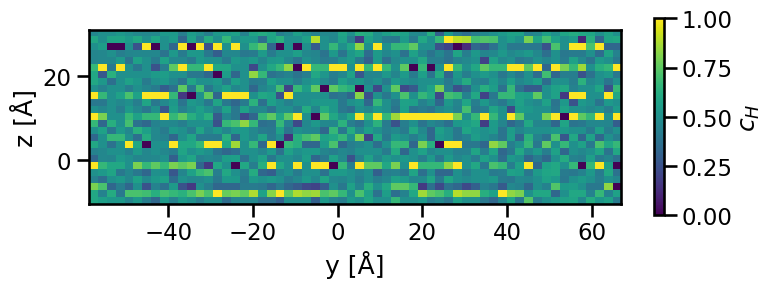

In [45]:
# ----------- PARAMETERS -----------
dump_file = "out.dump"
frame = -1  # Use last frame (-1)
nbins_y = 60  # Grid resolution
nbins_z = 25  # Grid resolution
# ----------------------------------

# --- Simple LAMMPS dump reader ---
def read_lammps_dump(filename, frame=-1):
    with open(filename) as f:
        lines = f.readlines()

    snapshots = []
    i = 0
    while i < len(lines):
        if "ITEM: TIMESTEP" in lines[i]:
            timestep = int(lines[i+1])
            n_atoms = int(lines[i+3])
            box_bounds = [list(map(float, lines[i+5].split())),
                          list(map(float, lines[i+6].split())),
                          list(map(float, lines[i+7].split()))]
            atom_start = i + 9
            atom_data = []
            for j in range(n_atoms):
                atom_data.append(lines[atom_start + j].split())
            snapshots.append((timestep, np.array(atom_data, dtype=float)))
            i = atom_start + n_atoms
        else:
            i += 1

    return snapshots[frame]

# --- Load snapshot ---
timestep, atoms = read_lammps_dump(dump_file, frame)
ids, types, x, y, z = atoms[:,0], atoms[:,1], atoms[:,2], atoms[:,3], atoms[:,4]

# --- Grid setup in the y–z plane ---
y_edges = np.linspace(min(y), max(y), nbins_y+1)
z_edges = np.linspace(min(z), max(z), nbins_z+1)

# --- Count H and Pd atoms per bin ---
H_mask = (types == 1)
Pd_mask = (types == 2)

H_hist, _, _ = np.histogram2d(y[H_mask], z[H_mask], bins=[y_edges, z_edges])
Pd_hist, _, _ = np.histogram2d(y[Pd_mask], z[Pd_mask], bins=[y_edges, z_edges])

# --- Compute local concentration c_H = H / (H + Pd) ---
with np.errstate(divide='ignore', invalid='ignore'):
    c_H = np.nan_to_num(H_hist / (H_hist + Pd_hist))

# --- Plot ---
plt.figure(figsize=(8, 3))
plt.imshow(c_H.T, origin='lower',
           extent=[min(y), max(y), min(z), max(z)],
           cmap='viridis', vmin=0, vmax=1, aspect='equal')

plt.colorbar(label='$c_H$')
plt.xlabel("y [Å]")
plt.ylabel("z [Å]")

plt.tight_layout()
plt.show()

# pre-processing (not for the students)

## delete 98% of H

In [13]:
import random

input_file = "structure.data"
output_file = "structure_thinned.data"
fraction_to_keep = 0.02

with open(input_file, 'r') as f:
    lines = f.readlines()

# Locate sections
atom_start_idx = next(i for i, line in enumerate(lines) if line.strip().startswith("Atoms"))
header = lines[:atom_start_idx + 2]
atom_lines = lines[atom_start_idx + 2:]
atom_lines = [line for line in atom_lines if line.strip()]

# Separate atoms
h_atoms = [line for line in atom_lines if line.split()[1] == "1"]
pd_atoms = [line for line in atom_lines if line.split()[1] == "2"]

# Randomly select H atoms to keep
n_keep = int(len(h_atoms) * fraction_to_keep)
kept_h = random.sample(h_atoms, n_keep)

# Combine and reassign atom IDs
new_atoms = kept_h + pd_atoms
new_atoms.sort(key=lambda line: int(line.split()[0]))
for i, line in enumerate(new_atoms, 1):
    parts = line.split()
    parts[0] = str(i)
    new_atoms[i - 1] = " ".join(parts) + "\n"

# Update atom count in header
for i, line in enumerate(header):
    if "atoms" in line:
        header[i] = f"{len(new_atoms)} atoms\n"
        break

# Write new file
with open(output_file, 'w') as f:
    f.writelines(header)
    f.write("\n")
    f.write("".join(new_atoms))

print(f"Done. Kept {n_keep} H atoms out of {len(h_atoms)}. New file: {output_file}")

Done. Kept 151 H atoms out of 7560. New file: structure_thinned.data


## equilibrate 300 K

In [ ]:
%%writefile PdH_equilibration.in
# Set up units and boundaries
units       metal
boundary    p p p
atom_style  atomic

# Read input data
read_data   structure_thinned.data

# Define masses for atomic types
mass 1      1.00794  # H
mass 2      106.42  # Pd 

pair_style eam/alloy
pair_coeff * * PdH_Zhou_June29_2007_2.eam.alloy H Pd

##################################
# Parameters #
variable    randomSeed equal        40         
variable    timeStepLength equal    0.001    # In ps
variable    tDamp equal             0.1      # Thermostat damping (ps)
variable    pDamp equal             1        # Barostat damping (ps)
variable    velocity equal          600      # 
variable    startingTemp equal      300      # Initial temperature in K
variable    externalPressure equal  0.0      # External pressure in atm
variable    run1 equal              50000   # Steps 
##################################

group Hatoms    type 1 
compute         Hmsd Hatoms msd com yes

# Set timestep
timestep    ${timeStepLength}

# Starting simulation

thermo_style custom step temp press ke pe etotal vol enthalpy c_Hmsd[*]
thermo_modify flush yes
thermo 100

#dump        dump1 all custom 5000 equil.traj.*.dump id type xu yu zu vx vy vz fx fy fz 

velocity all create ${velocity} ${randomSeed} mom yes rot yes

# Step 1: 
fix         1 all npt temp ${startingTemp} ${startingTemp} ${tDamp} iso ${externalPressure} ${externalPressure} ${pDamp}
run         ${run1}
unfix       1

# Save final configuration including velocities
write_data PdH_equilibrated_300.data

Overwriting PdH_equilibration.in


In [31]:
!mpirun -np 8 lmp_mpi < PdH_equilibration.in

LAMMPS (29 Aug 2024 - Update 2)
Reading data file ...
  triclinic box = (-12.324462 -57.514156 -16.432616) to (16.432616 65.730464 38.54077) with tilt (-9e-15 4.014459e-15 4.014459e-15)
  1 by 4 by 2 MPI processor grid
  reading atoms ...
  7711 atoms
  read_data CPU = 0.048 seconds
151 atoms in group Hatoms
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 7.35
  ghost atom cutoff = 7.35
  binsize = 3.675, bins = 8 34 15
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair eam/alloy, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton/tri
      stencil: half/bin/3d/tri
      bin: standard
Setting up Verlet run ...
  Unit style    : metal
  Current step  : 0
  Time step     : 0.001
Per MPI rank memory allocation (min/avg/max) = 3.825 | 3.827 | 3.828 Mbytes
   Step          Temp          Press          KinEng         PotEng         To

## equilibrate 350 K

In [ ]:
%%writefile PdH_equilibration.in
# Set up units and boundaries
units       metal
boundary    p p p
atom_style  atomic

# Read input data
read_data   PdH_equilibrated_300.data

# Define masses for atomic types
mass 1      1.00794  # H
mass 2      106.42  # Pd 

pair_style eam/alloy
pair_coeff * * PdH_Zhou_June29_2007_2.eam.alloy H Pd

##################################
# Parameters #
variable    randomSeed equal        40       # Your matriculation number  
variable    timeStepLength equal    0.001    # In ps
variable    tDamp equal             0.1      # Thermostat damping (ps)
variable    pDamp equal             1        # Barostat damping (ps)
variable    startingTemp equal      350      # Initial temperature in K
variable    externalPressure equal  0.0      # External pressure in atm
variable    run1 equal              50000   # Steps 
##################################

group Hatoms    type 1 
compute         Hmsd Hatoms msd com yes

# Set timestep
timestep    ${timeStepLength}

# Starting simulation

thermo_style custom step temp press ke pe etotal vol enthalpy c_Hmsd[*]
thermo_modify flush yes
thermo 100

#dump        dump1 all custom 5000 equil.traj.*.dump id type xu yu zu vx vy vz fx fy fz 


# Step 1: 
fix         1 all npt temp ${startingTemp} ${startingTemp} ${tDamp} iso ${externalPressure} ${externalPressure} ${pDamp}
run         ${run1}
unfix       1

# Save final configuration including velocities
write_data PdH_equilibrated_350.data

Overwriting PdH_equilibration.in


In [66]:
!mpirun -np 8 lmp_mpi < PdH_equilibration.in

LAMMPS (29 Aug 2024 - Update 2)
Reading data file ...
  triclinic box = (-11.4747 -53.872319 -14.808171) to (15.582854 62.088627 36.916325) with tilt (-8.4681061e-15 3.7772072e-15 3.7772072e-15)
  1 by 4 by 2 MPI processor grid
  reading atoms ...
  7711 atoms
  reading velocities ...
  7711 velocities
  read_data CPU = 0.076 seconds
151 atoms in group Hatoms
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 7.35
  ghost atom cutoff = 7.35
  binsize = 3.675, bins = 8 32 15
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair eam/alloy, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton/tri
      stencil: half/bin/3d/tri
      bin: standard
Setting up Verlet run ...
  Unit style    : metal
  Current step  : 0
  Time step     : 0.001
Per MPI rank memory allocation (min/avg/max) = 3.825 | 3.827 | 3.829 Mbytes
   Step          Temp     

## equilibrate 400 K

In [75]:
%%writefile PdH_equilibration.in
# Set up units and boundaries
units       metal
boundary    p p p
atom_style  atomic

# Read input data
read_data   PdH_equilibrated_350.data

# Define masses for atomic types
mass 1      1.00794  # H
mass 2      106.42  # Pd 

pair_style eam/alloy
pair_coeff * * PdH_Zhou_June29_2007_2.eam.alloy H Pd

##################################
# Parameters #
variable    randomSeed equal        40         
variable    timeStepLength equal    0.001    # In ps
variable    tDamp equal             0.1      # Thermostat damping (ps)
variable    pDamp equal             1        # Barostat damping (ps)
variable    startingTemp equal      400      # Initial temperature in K
variable    externalPressure equal  0.0      # External pressure in atm
variable    run1 equal              50000   # Steps 
##################################

group Hatoms    type 1 
compute         Hmsd Hatoms msd com yes

# Set timestep
timestep    ${timeStepLength}

# Starting simulation

thermo_style custom step temp press ke pe etotal vol enthalpy c_Hmsd[*]
thermo_modify flush yes
thermo 100

#dump        dump1 all custom 5000 equil.traj.*.dump id type xu yu zu vx vy vz fx fy fz 


# Step 1: 
fix         1 all npt temp ${startingTemp} ${startingTemp} ${tDamp} iso ${externalPressure} ${externalPressure} ${pDamp}
run         ${run1}
unfix       1

# Save final configuration including velocities
write_data PdH_equilibrated_400.data

Overwriting PdH_equilibration.in


In [76]:
!mpirun -np 8 lmp_mpi < PdH_equilibration.in

LAMMPS (29 Aug 2024 - Update 2)
Reading data file ...
  triclinic box = (-11.454339 -53.785056 -14.769247) to (15.562493 62.001364 36.877401) with tilt (-8.4553612e-15 3.7715223e-15 3.7715223e-15)
  1 by 4 by 2 MPI processor grid
  reading atoms ...
  7711 atoms
  reading velocities ...
  7711 velocities
  read_data CPU = 0.103 seconds
151 atoms in group Hatoms
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 7.35
  ghost atom cutoff = 7.35
  binsize = 3.675, bins = 8 32 15
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair eam/alloy, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton/tri
      stencil: half/bin/3d/tri
      bin: standard
Setting up Verlet run ...
  Unit style    : metal
  Current step  : 0
  Time step     : 0.001
Per MPI rank memory allocation (min/avg/max) = 3.825 | 3.827 | 3.828 Mbytes
   Step          Temp   

## equilibrate 450 K

In [89]:
%%writefile PdH_equilibration.in
# Set up units and boundaries
units       metal
boundary    p p p
atom_style  atomic

# Read input data
read_data   PdH_equilibrated_400.data

# Define masses for atomic types
mass 1      1.00794  # H
mass 2      106.42  # Pd 

pair_style eam/alloy
pair_coeff * * PdH_Zhou_June29_2007_2.eam.alloy H Pd

##################################
# Parameters #
variable    randomSeed equal        40         
variable    timeStepLength equal    0.001    # In ps
variable    tDamp equal             0.1      # Thermostat damping (ps)
variable    pDamp equal             1        # Barostat damping (ps)
variable    startingTemp equal      450      # Initial temperature in K
variable    externalPressure equal  0.0      # External pressure in atm
variable    run1 equal              50000   # Steps 
##################################

group Hatoms    type 1 
compute         Hmsd Hatoms msd com yes

# Set timestep
timestep    ${timeStepLength}

# Starting simulation

thermo_style custom step temp press ke pe etotal vol enthalpy c_Hmsd[*]
thermo_modify flush yes
thermo 100

#dump        dump1 all custom 5000 equil.traj.*.dump id type xu yu zu vx vy vz fx fy fz 


# Step 1: 
fix         1 all npt temp ${startingTemp} ${startingTemp} ${tDamp} iso ${externalPressure} ${externalPressure} ${pDamp}
run         ${run1}
unfix       1

# Save final configuration including velocities
write_data PdH_equilibrated_450.data

Overwriting PdH_equilibration.in


In [90]:
!mpirun -np 8 lmp_mpi < PdH_equilibration.in

LAMMPS (29 Aug 2024 - Update 2)
Reading data file ...
  triclinic box = (-11.430704 -53.683764 -14.724066) to (15.538858 61.900072 36.83222) with tilt (-8.4405675e-15 3.7649236e-15 3.7649236e-15)
  1 by 4 by 2 MPI processor grid
  reading atoms ...
  7711 atoms
  reading velocities ...
  7711 velocities
  read_data CPU = 0.072 seconds
151 atoms in group Hatoms
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 7.35
  ghost atom cutoff = 7.35
  binsize = 3.675, bins = 8 32 15
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair eam/alloy, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton/tri
      stencil: half/bin/3d/tri
      bin: standard
Setting up Verlet run ...
  Unit style    : metal
  Current step  : 0
  Time step     : 0.001
Per MPI rank memory allocation (min/avg/max) = 3.824 | 3.827 | 3.829 Mbytes
   Step          Temp    

## equilibrate 500 K

In [101]:
%%writefile PdH_equilibration.in
# Set up units and boundaries
units       metal
boundary    p p p
atom_style  atomic

# Read input data
read_data   PdH_equilibrated_450.data

# Define masses for atomic types
mass 1      1.00794  # H
mass 2      106.42  # Pd 

pair_style eam/alloy
pair_coeff * * PdH_Zhou_June29_2007_2.eam.alloy H Pd

##################################
# Parameters #
variable    randomSeed equal        40         
variable    timeStepLength equal    0.001    # In ps
variable    tDamp equal             0.1      # Thermostat damping (ps)
variable    pDamp equal             1        # Barostat damping (ps)
variable    startingTemp equal      500      # Initial temperature in K
variable    externalPressure equal  0.0      # External pressure in atm
variable    run1 equal              50000   # Steps 
##################################

group Hatoms    type 1 
compute         Hmsd Hatoms msd com yes

# Set timestep
timestep    ${timeStepLength}

# Starting simulation

thermo_style custom step temp press ke pe etotal vol enthalpy c_Hmsd[*]
thermo_modify flush yes
thermo 100

#dump        dump1 all custom 5000 equil.traj.*.dump id type xu yu zu vx vy vz fx fy fz 


# Step 1: 
fix         1 all npt temp ${startingTemp} ${startingTemp} ${tDamp} iso ${externalPressure} ${externalPressure} ${pDamp}
run         ${run1}
unfix       1

# Save final configuration including velocities
write_data PdH_equilibrated_500.data

Overwriting PdH_equilibration.in


In [102]:
!mpirun -np 8 lmp_mpi < PdH_equilibration.in

LAMMPS (29 Aug 2024 - Update 2)
Reading data file ...
  triclinic box = (-11.437646 -53.713514 -14.737336) to (15.5458 61.929822 36.84549) with tilt (-8.4449125e-15 3.7668617e-15 3.7668617e-15)
  1 by 4 by 2 MPI processor grid
  reading atoms ...
  7711 atoms
  reading velocities ...
  7711 velocities
  read_data CPU = 0.091 seconds
151 atoms in group Hatoms
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 7.35
  ghost atom cutoff = 7.35
  binsize = 3.675, bins = 8 32 15
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair eam/alloy, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton/tri
      stencil: half/bin/3d/tri
      bin: standard
Setting up Verlet run ...
  Unit style    : metal
  Current step  : 0
  Time step     : 0.001
Per MPI rank memory allocation (min/avg/max) = 3.824 | 3.826 | 3.827 Mbytes
   Step          Temp      

# Exercise: Diffusion of Hydrogen in Palladium

Molecular dynamics (MD) simulations are a powerful tool for understanding the atomic-scale mechanisms that underlie real-world materials behavior. In fields like hydrogen storage, fuel cells, and catalysis, the ability of hydrogen to diffuse through metals such as palladium is of critical importance. However, these processes are difficult to observe directly at the atomic level.

In this exercise, you will study the diffusion of hydrogen (H) atoms in a palladium (Pd) matrix using molecular dynamics simulations. Palladium has a face-centered cubic (FCC) structure, and hydrogen atoms occupy interstitial sites, forming an interstitial solid solution.

You are provided with equilibrated atomic configurations of Pd with a dilute concentration of hydrogen at different temperatures (350 K, 400 K, 450 K, 500 K). Your task is to analyze how hydrogen atoms move through the Pd lattice over time, and to extract physical insights about the diffusion process.

Specifically, you will:

- Load time-resolved mean squared displacement (MSD) data for H atoms,
- Fit a linear model to the MSD vs. time curves to determine diffusion coefficients at each temperature,
- Construct an Arrhenius plot of $\ln D$ vs. $1/T$ to extract the activation energy for hydrogen diffusion in palladium.

# production runs

## production run 350 K

1. In the cell below, insert your matriculation number at the end of the line `variable    randomSeed equal`

2. Execute the cell to generate a LAMMPS input script for a simulation at 350 K.  

3. Then run the next cell to submit the simulation.

Once the simulation at 350 K is complete:

4. Duplicate both cells and adapt them to run simulations at the other temperatures of interest: 400 K, 450 K, and 500 K.

**Important:**  
Make sure to update all temperature-specific values in both the input script and the submission command, including:
- The target temperature,
- Output file names (to avoid overwriting),
- Any labels used in filenames, variables, or logs.

In [ ]:
%%writefile PdH_solid_solution.in
# Set up units and boundaries
units       metal
boundary    p p p
atom_style  atomic

# Read input data
read_data   PdH_equilibrated_350.data

# Define masses for atomic types
mass 1      1.00794  # H
mass 2      106.42  # Pd 

pair_style eam/alloy
pair_coeff * * PdH_Zhou_June29_2007_2.eam.alloy H Pd

##################################
# Parameters #
variable    randomSeed equal        40       # Your matriculation number  
variable    timeStepLength equal    0.001    # In ps
variable    tDamp equal             0.1      # Thermostat damping (ps)
variable    pDamp equal             1        # Barostat damping (ps)
variable    startingTemp equal      350      # Initial temperature in K
variable    externalPressure equal  0.0      # External pressure in atm
variable    run1 equal              50000   # Steps 
##################################

group Hatoms    type 1 
compute         Hmsd Hatoms msd com yes
variable        time equal step*${timeStepLength}

fix msdout all ave/time 100 1 100 c_Hmsd[4] file msd_H_350.txt

# Set timestep
timestep    ${timeStepLength}

# Starting simulation

thermo_style custom step temp press ke pe etotal vol enthalpy c_Hmsd[*]
thermo_modify flush yes
thermo 100

dump        dump1 all custom 5000 350.traj.dump id type x y z

# Step 1: 
fix         1 all npt temp ${startingTemp} ${startingTemp} ${tDamp} iso ${externalPressure} ${externalPressure} ${pDamp}
run         ${run1}
unfix       1

Overwriting PdH_solid_solution.in


In [70]:
!mpirun -np 8 lmp_mpi < PdH_solid_solution.in

LAMMPS (29 Aug 2024 - Update 2)
Reading data file ...
  triclinic box = (-11.454339 -53.785056 -14.769247) to (15.562493 62.001364 36.877401) with tilt (-8.4553612e-15 3.7715223e-15 3.7715223e-15)
  1 by 4 by 2 MPI processor grid
  reading atoms ...
  7711 atoms
  reading velocities ...
  7711 velocities
  read_data CPU = 0.078 seconds
151 atoms in group Hatoms
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 7.35
  ghost atom cutoff = 7.35
  binsize = 3.675, bins = 8 32 15
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair eam/alloy, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton/tri
      stencil: half/bin/3d/tri
      bin: standard
Setting up Verlet run ...
  Unit style    : metal
  Current step  : 0
  Time step     : 0.001
Per MPI rank memory allocation (min/avg/max) = 3.825 | 3.827 | 3.828 Mbytes
   Step          Temp   

## production run 400 K

In [77]:
%%writefile PdH_solid_solution.in
# Set up units and boundaries
units       metal
boundary    p p p
atom_style  atomic

# Read input data
read_data   PdH_equilibrated_400.data       ###

# Define masses for atomic types
mass 1      1.00794  # H
mass 2      106.42  # Pd 

pair_style eam/alloy
pair_coeff * * PdH_Zhou_June29_2007_2.eam.alloy H Pd

##################################
# Parameters #
variable    randomSeed equal        40         
variable    timeStepLength equal    0.001    # In ps
variable    tDamp equal             0.1      # Thermostat damping (ps)
variable    pDamp equal             1        # Barostat damping (ps)
variable    startingTemp equal      400      # Initial temperature in K     ###
variable    externalPressure equal  0.0      # External pressure in atm
variable    run1 equal              50000    # Steps 
##################################

group Hatoms    type 1 
compute         Hmsd Hatoms msd com yes
variable        time equal step*${timeStepLength}

fix msdout all ave/time 100 1 100 c_Hmsd[4] file msd_H_400.txt      ###

# Set timestep
timestep    ${timeStepLength}

# Starting simulation

thermo_style custom step temp press ke pe etotal vol enthalpy c_Hmsd[*]
thermo_modify flush yes
thermo 100

dump        dump1 all custom 5000 400.traj.dump id type x y z       ###

# Step 1: 
fix         1 all npt temp ${startingTemp} ${startingTemp} ${tDamp} iso ${externalPressure} ${externalPressure} ${pDamp}
run         ${run1}
unfix       1

Overwriting PdH_solid_solution.in


In [78]:
!mpirun -np 8 lmp_mpi < PdH_solid_solution.in

LAMMPS (29 Aug 2024 - Update 2)
Reading data file ...
  triclinic box = (-11.430704 -53.683764 -14.724066) to (15.538858 61.900072 36.83222) with tilt (-8.4405675e-15 3.7649236e-15 3.7649236e-15)
  1 by 4 by 2 MPI processor grid
  reading atoms ...
  7711 atoms
  reading velocities ...
  7711 velocities
  read_data CPU = 0.086 seconds
151 atoms in group Hatoms
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 7.35
  ghost atom cutoff = 7.35
  binsize = 3.675, bins = 8 32 15
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair eam/alloy, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton/tri
      stencil: half/bin/3d/tri
      bin: standard
Setting up Verlet run ...
  Unit style    : metal
  Current step  : 0
  Time step     : 0.001
Per MPI rank memory allocation (min/avg/max) = 3.824 | 3.827 | 3.829 Mbytes
   Step          Temp    

## production run 450 K

In [91]:
%%writefile PdH_solid_solution.in
# Set up units and boundaries
units       metal
boundary    p p p
atom_style  atomic

# Read input data
read_data   PdH_equilibrated_450.data       ###

# Define masses for atomic types
mass 1      1.00794  # H
mass 2      106.42  # Pd 

pair_style eam/alloy
pair_coeff * * PdH_Zhou_June29_2007_2.eam.alloy H Pd

##################################
# Parameters #
variable    randomSeed equal        40         
variable    timeStepLength equal    0.001    # In ps
variable    tDamp equal             0.1      # Thermostat damping (ps)
variable    pDamp equal             1        # Barostat damping (ps)
variable    startingTemp equal      450      # Initial temperature in K     ###
variable    externalPressure equal  0.0      # External pressure in atm
variable    run1 equal              50000    # Steps 
##################################

group Hatoms    type 1 
compute         Hmsd Hatoms msd com yes
variable        time equal step*${timeStepLength}

fix msdout all ave/time 100 1 100 c_Hmsd[4] file msd_H_450.txt      ###

# Set timestep
timestep    ${timeStepLength}

# Starting simulation

thermo_style custom step temp press ke pe etotal vol enthalpy c_Hmsd[*]
thermo_modify flush yes
thermo 100

dump        dump1 all custom 5000 450.traj.dump id type x y z       ###

# Step 1: 
fix         1 all npt temp ${startingTemp} ${startingTemp} ${tDamp} iso ${externalPressure} ${externalPressure} ${pDamp}
run         ${run1}
unfix       1

Overwriting PdH_solid_solution.in


In [92]:
!mpirun -np 8 lmp_mpi < PdH_solid_solution.in

LAMMPS (29 Aug 2024 - Update 2)
Reading data file ...
  triclinic box = (-11.437646 -53.713514 -14.737336) to (15.5458 61.929822 36.84549) with tilt (-8.4449125e-15 3.7668617e-15 3.7668617e-15)
  1 by 4 by 2 MPI processor grid
  reading atoms ...
  7711 atoms
  reading velocities ...
  7711 velocities
  read_data CPU = 0.088 seconds
151 atoms in group Hatoms
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 7.35
  ghost atom cutoff = 7.35
  binsize = 3.675, bins = 8 32 15
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair eam/alloy, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton/tri
      stencil: half/bin/3d/tri
      bin: standard
Setting up Verlet run ...
  Unit style    : metal
  Current step  : 0
  Time step     : 0.001
Per MPI rank memory allocation (min/avg/max) = 3.824 | 3.826 | 3.827 Mbytes
   Step          Temp      

## production run 500 K

In [ ]:
%%writefile PdH_solid_solution.in
# Set up units and boundaries
units       metal
boundary    p p p
atom_style  atomic

# Read input data
read_data   PdH_equilibrated_500.data       ###

# Define masses for atomic types
mass 1      1.00794  # H
mass 2      106.42  # Pd 

pair_style eam/alloy
pair_coeff * * PdH_Zhou_June29_2007_2.eam.alloy H Pd

##################################
# Parameters #
variable    randomSeed equal        40       # Matriculation number
variable    timeStepLength equal    0.001    # In ps
variable    tDamp equal             0.1      # Thermostat damping (ps)
variable    pDamp equal             1        # Barostat damping (ps)
variable    startingTemp equal      500      # Initial temperature in K     ###
variable    externalPressure equal  0.0      # External pressure in atm
variable    run1 equal              50000    # Steps 
##################################

group Hatoms    type 1 
compute         Hmsd Hatoms msd com yes
variable        time equal step*${timeStepLength}

fix msdout all ave/time 100 1 100 c_Hmsd[4] file msd_H_500.txt      ###

# Set timestep
timestep    ${timeStepLength}

# Starting simulation

thermo_style custom step temp press ke pe etotal vol enthalpy c_Hmsd[*]
thermo_modify flush yes
thermo 100

dump        dump1 all custom 5000 500.traj.dump id type x y z       ###

# Step 1: 
fix         1 all npt temp ${startingTemp} ${startingTemp} ${tDamp} iso ${externalPressure} ${externalPressure} ${pDamp}
run         ${run1}
unfix       1

Overwriting PdH_solid_solution.in


In [104]:
!mpirun -np 8 lmp_mpi < PdH_solid_solution.in

LAMMPS (29 Aug 2024 - Update 2)
Reading data file ...
  triclinic box = (-11.470697 -53.855162 -14.800518) to (15.578851 62.07147 36.908672) with tilt (-8.4656003e-15 3.7760895e-15 3.7760895e-15)
  1 by 4 by 2 MPI processor grid
  reading atoms ...
  7711 atoms
  reading velocities ...
  7711 velocities
  read_data CPU = 0.078 seconds
151 atoms in group Hatoms
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 7.35
  ghost atom cutoff = 7.35
  binsize = 3.675, bins = 8 32 15
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair eam/alloy, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton/tri
      stencil: half/bin/3d/tri
      bin: standard
Setting up Verlet run ...
  Unit style    : metal
  Current step  : 0
  Time step     : 0.001
Per MPI rank memory allocation (min/avg/max) = 3.824 | 3.826 | 3.828 Mbytes
   Step          Temp    

# post-processing

In this step, you will load the MSD data for hydrogen diffusion from your simulations at different temperatures, merge them into a single DataFrame, and create a time axis.

1. Identify the correct output files for each temperature. You can find the filenames either in your LAMMPS input scripts or directly in your working folder.  
Then, replace `'name of the text file'` with the actual filenames in the code snippet below.

2. Use the provided snippet to:
    - Load each file using `pd.read_csv`,
    - Merge the DataFrames on the `Step` column (which represents simulation time steps),
    - Convert the timestep to time in picoseconds,
    - Reorder columns for clarity.

3. Execute the cell once all file names are correctly inserted. You should see a table with time and MSD values at all four temperatures.

If you are proficient in Python, feel free to implement your own solution using loops or functions, as long as the final output matches the expected format.

```python
# Time conversion: 1 timestep = 1 fs = 0.001 ps
timestep_fs = 1
fs_to_ps = 0.001

# Load all MSD files
df_350 = pd.read_csv('name of the text file', comment='#', sep='\s+', names=['Step','MSD 350K'])
df_400 = ...
...

# Merge on Step
df = df_350.merge(df_400, on='Step').merge(df_450, on='Step').merge(df_500, on='Step')

# Add Time column in ps
df['Time [ps]'] = df['Step'] * timestep_fs * fs_to_ps

# Reorder columns
df = df[['Step', 'Time [ps]', 'MSD 350K', 'MSD 400K', 'MSD 450K', 'MSD 500K']]

# Show result
df.head()
```

In [2]:
# Time conversion: 1 timestep = 1 fs = 0.001 ps
timestep_fs = 1
fs_to_ps = 0.001

# Load all MSD files
df_350 = pd.read_csv('msd_H_350.txt', comment='#', sep='\s+', names=['Step','MSD 350K'])
df_400 = pd.read_csv('msd_H_400.txt', comment='#', sep='\s+', names=['Step','MSD 400K'])
df_450 = pd.read_csv('msd_H_450.txt', comment='#', sep='\s+', names=['Step','MSD 450K'])
df_500 = pd.read_csv('msd_H_500.txt', comment='#', sep='\s+', names=['Step','MSD 500K'])

# Merge on Step
df = df_350.merge(df_400, on='Step').merge(df_450, on='Step').merge(df_500, on='Step')

# Add Time column in ps
df['Time [ps]'] = df['Step'] * timestep_fs * fs_to_ps

# Reorder columns
df = df[['Step', 'Time [ps]', 'MSD 350K', 'MSD 400K', 'MSD 450K', 'MSD 500K']]


# Show result
df.head()

,Step,Time [ps],MSD 350K,MSD 400K,MSD 450K,MSD 500K
0,0,0.0,7.936670e-29,3.623540e-29,5.465080e-29,2.617350e-30
1,100,0.1,4.335340e-01,3.517140e-01,5.477390e-01,4.216280e-01
2,200,0.2,5.377310e-01,4.748420e-01,9.318090e-01,6.213570e-01
3,300,0.3,7.255200e-01,6.261740e-01,1.258270e+00,8.770060e-01
4,400,0.4,7.344140e-01,7.487240e-01,1.510420e+00,1.506470e+00


```python
sns.lineplot(x=df['header of the x column'], y=df['header of the y column'], label='temperature of choice')
sns.lineplot(...)
...

plt.xlabel('Time [ps]')
plt.ylabel('MSD [Å²]')

plt.grid(True, alpha=0.5)
plt.show()
```

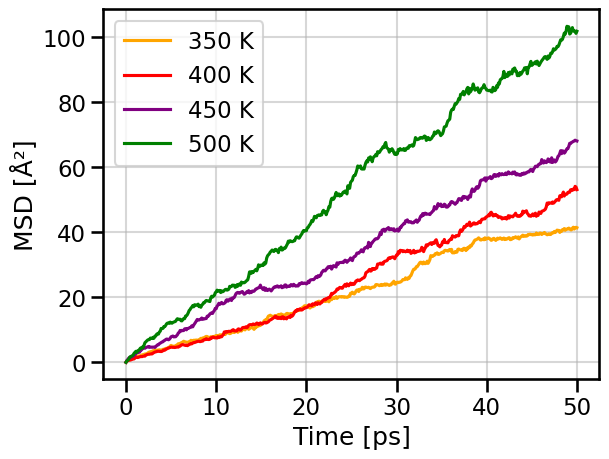

In [23]:
sns.lineplot(x=df['Time [ps]'], y=df['MSD 350K'], label='350 K', color='orange')
sns.lineplot(x=df['Time [ps]'], y=df['MSD 400K'], label='400 K', color='red')
sns.lineplot(x=df['Time [ps]'], y=df['MSD 450K'], label='450 K', color='purple')
sns.lineplot(x=df['Time [ps]'], y=df['MSD 500K'], label='500 K', color='green')

plt.xlabel('Time [ps]')
plt.ylabel('MSD [Å²]')

plt.grid(True, alpha=0.5)
plt.show()

Calculate the diffusion coefficient at the given temperatures by applying Einstein’s relation with $d=3$:
$$
\text{MSD}(t) = 2dDt
$$

The diffusion coefficient is extracted from the slope of the MSD vs. time curve, which we expect to be linear at long times:
$$
\text{MSD}(t) = a \cdot t + b
$$

Think about the physical meaning of MSD at time $t=0$.
What value should the MSD have at the very beginning of the simulation?
What does that tell you about the constant `b`?

Below is a generic function you can use for curve fitting: adapt it according to your answer to the previous question.

```python
from scipy.optimize import curve_fit

# Linear model: MSD(t) = a * t + b
def msd_model(t, a, b):
    return a * t + b
```

<details>
<summary>Spoiler Alert</summary>

If you reasoned that MSD should be zero at $t = 0$, you're right! Here's a simplified model that reflects that:

```python
# MSD(t) = a * t, with zero intercept
def msd_model(t, a):
    return a * t
```
</details> 

Adapt the following code snippet to extract the diffusion coefficient $D$ at each temperature using your merged DataFrame.

- Replace `'header of the x column'` with `'Time [ps]'`.

- Replace `'header of the y column'` with the MSD column corresponding to the temperature you're working with (e.g., `'MSD 350K'`).

- Set the correct dimensionality of the system, so the denominator becomes $2d$ in the Einstein relation.

```python
t = df['header of the x column']
msd_350 = df['header of the x column']

# Fit and extract D
popt_350, _ = curve_fit(msd_model, t, msd_350)

D_350 = popt_350[0] / 2*d

print(f"T = 350 K: D = {D_350:.2e} Å²/ps")
```

Repeat this process for the other temperatures by adapting the MSD column name and label in `print()`.

Bonus: Try fitting with and without the intercept. Do you see a difference in extracted $D$?
What might cause a non-zero intercept?

In [7]:
# MSD(t) = a * t, with zero intercept
def msd_model(t, a):
    return a * t

In [46]:
t = df['Time [ps]']
msd_350 = df['MSD 350K']

# Fit and extract D
popt_350, _ = curve_fit(msd_model, t, msd_350)

D_350 = popt_350[0] / 6

print(f"T = 350 K: D = {D_350:.2e} Å²/ps")


t = df['Time [ps]']
msd_400 = df['MSD 400K']

# Fit and extract D
popt_400, _ = curve_fit(msd_model, t, msd_400)

D_400 = popt_400[0] / 6  # Extract the first element of the array

print(f"T = 400 K: D = {D_400:.2e} Å²/ps")


t = df['Time [ps]']
msd_450 = df['MSD 450K']

# Fit and extract D
popt_450, _ = curve_fit(msd_model, t, msd_450)

D_450 = popt_450[0] / 6  # Extract the first element of the array

print(f"T = 450 K: D = {D_450:.2e} Å²/ps")


t = df['Time [ps]']
msd_500 = df['MSD 500K']

# Fit and extract D
popt_500, _ = curve_fit(msd_model, t, msd_500)

D_500 = popt_500[0] / 6  # Extract the first element of the array

print(f"T = 500 K: D = {D_500:.2e} Å²/ps")

T = 350 K: D = 1.47e-01 Å²/ps
T = 400 K: D = 1.73e-01 Å²/ps
T = 450 K: D = 2.26e-01 Å²/ps
T = 500 K: D = 3.50e-01 Å²/ps


Now that you've extracted the diffusion coefficients 
D at different temperatures, it's time to organize your results in a table so you can use them for further analysis (like Arrhenius fitting).

1. Replace the placeholder list of `temperatures` with the actual values used in your simulations (e.g., 350).

2. Replace the list of `diffusion_coeffs` with the actual *variable names* (not the numerical values) you defined for each diffusion coefficient (e.g., D_350).

3. Run the cell to create a new DataFrame `df_diffusion_fits` with:
    - Temperature
    - Diffusion coefficient
    - Inverse temperature 
    - Natural logarithm of the diffusion coefficient 

```python
# Lists of values
temperatures = [temperatures values separated by commas]
diffusion_coeffs = [variable names of the diffusion coefficients, separated by commas]

# Create the DataFrame
df_diffusion_fits = pd.DataFrame({
    'T [K]': temperatures,
    'D [Å²/ps]': diffusion_coeffs
})

# Add derived columns
df_diffusion_fits['1/T [1/K]'] = 1 / df_diffusion_fits['T [K]']
df_diffusion_fits['ln D'] = np.log(df_diffusion_fits['D [Å²/ps]'])

# Show it
df_diffusion_fits
```

In [ ]:
# Lists of values
temperatures = [350, 400, 450, 500]
diffusion_coeffs = [D_350, D_400, D_450, D_500]

# Create the DataFrame
df_diffusion_fits = pd.DataFrame({
    'T [K]': temperatures,
    'D [Å²/ps]': diffusion_coeffs
})

# Add derived columns
df_diffusion_fits['1/T [1/K]'] = 1 / df_diffusion_fits['T [K]']
df_diffusion_fits['ln D'] = np.log(df_diffusion_fits['D [Å²/ps]'])

# Show it
df_diffusion_fits

,T [K],D [Å²/ps],1/T [1/K],ln D
0,350,0.146816,0.002857,-1.918573
1,400,0.172602,0.002500,-1.756769
2,450,0.225953,0.002222,-1.487429
3,500,0.349743,0.002000,-1.050557


Execute the following snippet to it the natural logarithm of the diffusion coefficient $\ln D$ to a linear function of inverse temperature $1/T$, based on the Arrhenius equation:
$$
\ln D = \ln D_0 - \frac{E_a}{k_B T}
$$

This allows you to extract two important physical parameters:

- $D_0$: the pre-exponential factor (diffusivity at infinite temperature),

- $E_a$: the activation energy (energy barrier for diffusion), in eV.

In [16]:
# Extract values
invT = df_diffusion_fits['1/T [1/K]']
lnD = df_diffusion_fits['ln D']

# Define linear Arrhenius model
def arrhenius_ln(invT, slope, intercept):
    return slope * invT + intercept

# Fit
popt, pcov = curve_fit(arrhenius_ln, invT, lnD)
slope, intercept = popt

# Extract physical parameters
kB = 8.617e-5  # eV/K
Ea_eV = -slope * kB
D0 = np.exp(intercept)

print(f"Fitted activation energy Ea = {Ea_eV:.3f} eV")
print(f"Fitted pre-exponential factor D0 = {D0:.2e} Å²/ps")

Fitted activation energy Ea = 0.084 eV
Fitted pre-exponential factor D0 = 2.18e+00 Å²/ps


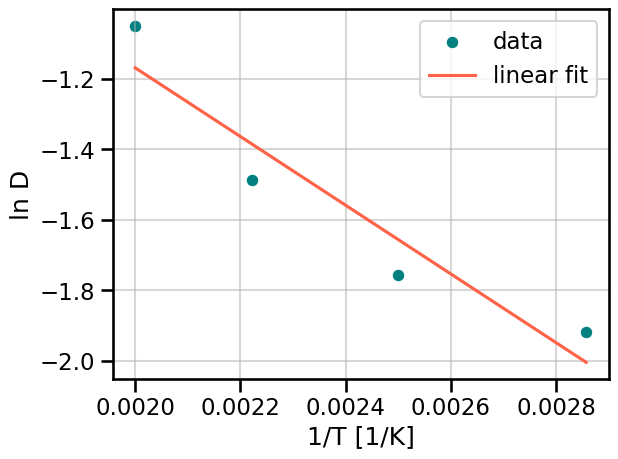

In [24]:
sns.scatterplot(x=invT, y=lnD, label='data', color='teal')
sns.lineplot(x=invT, y=arrhenius_ln(invT, slope, intercept), label='linear fit', color='tomato')

plt.xlabel('1/T [1/K]')
plt.ylabel('ln D')

plt.grid(True, alpha=0.5)
plt.legend()
plt.show()